In [11]:
from TMSAnalysis.StruckAnalysisConfiguration import StruckAnalysisConfiguration
from TMSAnalysis.TMSUtilities.GetCuts import Cut
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
from matplotlib import gridspec
import uproot, glob, time
import pandas as pd
import numpy as np

plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.size'] = 12

In [12]:
path_to_reduced = '/p/lustre1/jacopod/31th/'
!ls $path_to_reduced

20201023_DS04_BkgData_1200ADCThreshold	20201101_DS22_Xe127Data
20201024_DS06_Xe127Data			20201102_DS23_NoiseData
20201025_DS08_Xe127Data			20201102_DS24_Rn220Data
20201026_DS09_Xe127Data			20201103_DS25_Run220Data
20201026_DS10_Xe127Data			20201103_DS26_Run220Data
20201027_DS12_Xe127Data			20201104_DS27_Run220Data
20201030_DS15_Xe127Data			20201105_DS28_Rn220Data
20201031_DS16_Xe127Data			20201106_DS29_Rn220Data
20201031_DS17_Xe127Data			20201107_DS30_Rn220Data
20201031_DS18_Xe127Data			config


In [13]:
folder = '20201031_DS16_Xe127Data/analysis_500ns'
analysis_config = StruckAnalysisConfiguration.StruckAnalysisConfiguration()
analysis_config.GetRunParametersFromFile('/g/g90/jacopod/software/TMSAnalysis/config/31th/Run_Parameters_Run30.xlsx',\
                                         folder.split('/')[0])
sampling_time = analysis_config.run_parameters['Sampling Period [ns]']/1.e3
trigger_time = analysis_config.run_parameters['Pretrigger Length [samples]']
df = pd.read_pickle(path_to_reduced + folder + '/reduced_added.p')
for k in df.keys():
    print(k)

ChannelPositions
ChannelTypes
Cluster Drift Time
Cluster Energies
Cluster X-Pos
Cluster Y-Pos
Cluster Z-Pos
Event
File
IsFull3D
NumSiPMChannelsHit
NumTileChannelsHit
NumXTileChannelsHit
NumYTileChannelsHit
Number3DClusters
NumberOfClusters
SiPM 1-1 Baseline
SiPM 1-1 Baseline RMS
SiPM 1-1 Induced Charge
SiPM 1-1 Pulse Area
SiPM 1-1 Pulse Height
SiPM 1-1 Pulse Time
SiPM 1-1 T10
SiPM 1-1 T20
SiPM 1-1 T5
SiPM 1-1 T80
SiPM 1-1 T90
SiPM 1-3 Baseline
SiPM 1-3 Baseline RMS
SiPM 1-3 Induced Charge
SiPM 1-3 Pulse Area
SiPM 1-3 Pulse Height
SiPM 1-3 Pulse Time
SiPM 1-3 T10
SiPM 1-3 T20
SiPM 1-3 T5
SiPM 1-3 T80
SiPM 1-3 T90
SiPM 1-4 Baseline
SiPM 1-4 Baseline RMS
SiPM 1-4 Induced Charge
SiPM 1-4 Pulse Area
SiPM 1-4 Pulse Height
SiPM 1-4 Pulse Time
SiPM 1-4 T10
SiPM 1-4 T20
SiPM 1-4 T5
SiPM 1-4 T80
SiPM 1-4 T90
SiPM 2-1 Baseline
SiPM 2-1 Baseline RMS
SiPM 2-1 Induced Charge
SiPM 2-1 Pulse Area
SiPM 2-1 Pulse Height
SiPM 2-1 Pulse Time
SiPM 2-1 T10
SiPM 2-1 T20
SiPM 2-1 T5
SiPM 2-1 T80
SiPM 2-1 T90


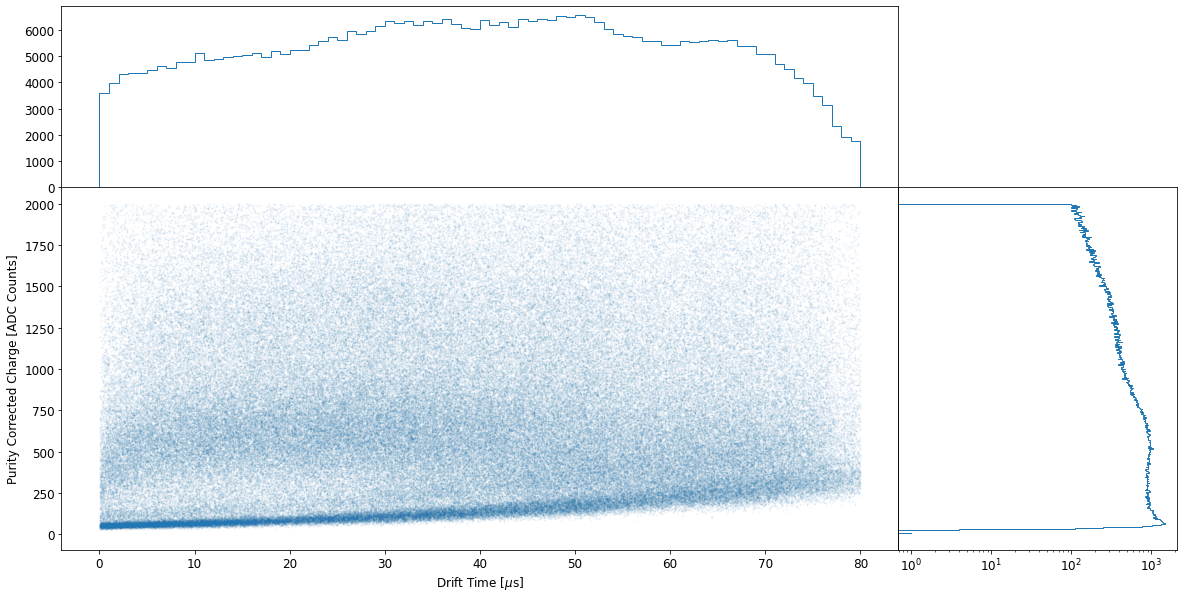

In [128]:
DriftTime = (df['TimeOfMaxChannel'] - trigger_time)*sampling_time
df['Purity-Corrected Charge Energy'] = df['TotalTileEnergy']*np.exp(DriftTime/50)
mask = (df['Purity-Corrected Charge Energy']<2000) & (DriftTime<80) & (DriftTime>0) & (df['TotalSiPMEnergy']>100)#&(df['NumberOfClusters']<2)#(df['TotalTileEnergy']>80)#
fig = plt.figure(figsize=(20, 10)) 
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[1,2],hspace=0,wspace=0)
ax1 = plt.subplot(gs[3])
ax2 = plt.subplot(gs[0]) 
ax0 = plt.subplot(gs[2],sharey=ax1,sharex=ax2)
ax0.scatter(DriftTime[mask], df['Purity-Corrected Charge Energy'][mask],s=1,alpha=0.05)
ax1.hist( df['Purity-Corrected Charge Energy'][mask],orientation="horizontal",bins=500,histtype='step',log=True)
ax2.hist(DriftTime[df['TotalTileEnergy']<1500],bins=80,range=(0,80),histtype='step')
#plt.title(folder.split('/')[0])
ax0.set_xlabel('Drift Time [$\mu$s]')
ax0.set_ylabel('Purity Corrected Charge [ADC Counts]')
plt.show()

(0.0, 10000.0)

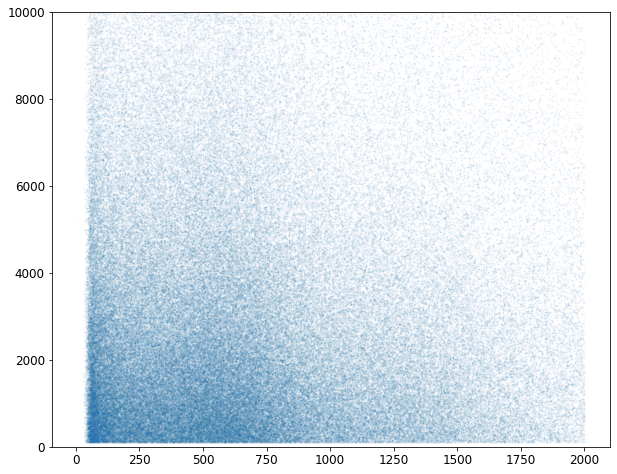

In [129]:
plt.scatter(df['Purity-Corrected Charge Energy'][mask], df['TotalSiPMEnergy'][mask],s=1,alpha=0.05)

plt.ylim(0,10000)

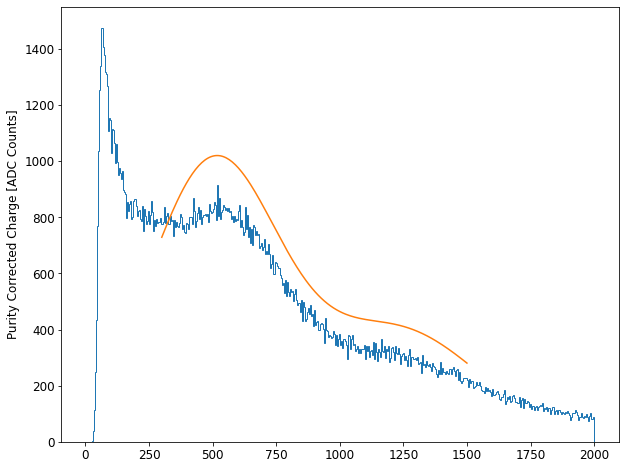

In [130]:
offset = 10
x = np.linspace(300,1500,200)
mask_time = mask & (df['WeightedPosZ']<1.79*DriftTime+offset) & (df['WeightedPosZ']>1.79*DriftTime-offset)
plt.hist(df['Purity-Corrected Charge Energy'][mask_time],bins=500,histtype='step')#,log=True)
plt.plot(x,980*np.exp(-np.square(x-500)/(2*65000))+400*np.exp(-np.square(x-1220)/(2*110000)))
plt.ylabel('Purity Corrected Charge [ADC Counts]')
plt.show()

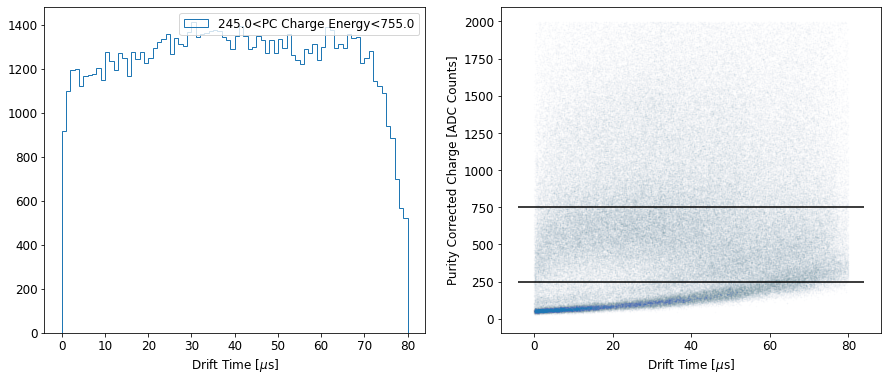

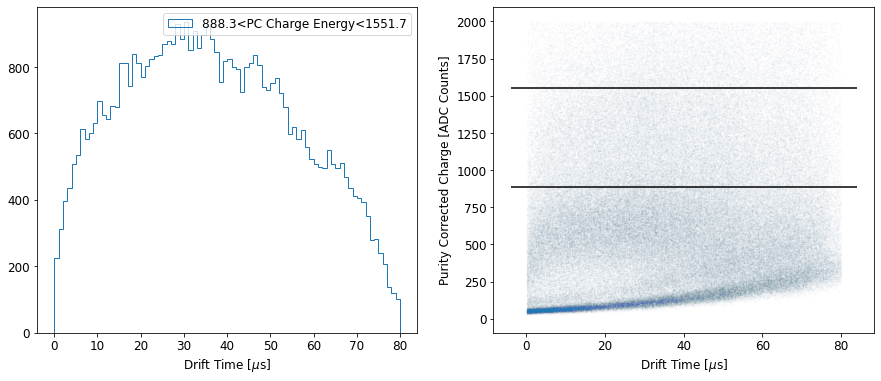

In [131]:
#energy_slice = np.linspace(0,2000,8)
energy_slice = ([500-np.sqrt(65000),500+np.sqrt(65000)],[1220-np.sqrt(110000),1220+np.sqrt(110000)])
for i,es in enumerate(energy_slice):
    try:
        #mask_slice = mask_time & (df['Purity-Corrected Charge Energy']<energy_slice[i+1]) & (df['Purity-Corrected Charge Energy']>es)
        mask_slice = mask_time & (df['Purity-Corrected Charge Energy']<es[1]) & (df['Purity-Corrected Charge Energy']>es[0])
    except IndexError:
        continue
    fig,(ax0,ax1) = plt.subplots(1,2,figsize=(15,6))
    ax0.hist(DriftTime[mask_slice],bins=80,range=(0,80),histtype='step',
             #label='{:.1f}<PC Charge Energy<{:.1f}'.format(es,energy_slice[i+1]))
             label='{:.1f}<PC Charge Energy<{:.1f}'.format(es[0],es[1]))
    ax0.set_xlabel('Drift Time [$\mu$s]')
    ax1.scatter(DriftTime[mask], df['Purity-Corrected Charge Energy'][mask],s=1,alpha=0.01)
    #ax1.hlines((energy_slice[i+1],es),ax1.get_xlim()[0],ax1.get_xlim()[1])
    ax1.hlines((es[1],es[0]),ax1.get_xlim()[0],ax1.get_xlim()[1])
    ax1.set_xlabel('Drift Time [$\mu$s]')
    ax1.set_ylabel('Purity Corrected Charge [ADC Counts]')
    ax0.legend()
    plt.show()